In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils import resample

In [2]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/lambda_max_v_bond_len_H_only.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")
# Effectively, I think of this as a left joining kraken_df on dft_df

In [3]:
# Now, as we found before, the model does not predict cases with a "symmetric methyl straddle" very well.
# I think this is because the overall agostic interaction is stronger (as in, Pd with two Hs).
# This notebook is to consider the model when we leave out these cases.
# So, drop these ligands here:
print(merged_df.shape)

symm_straddle_ids = [182847, 183055, 20097, 20103]

for m_id in symm_straddle_ids:
    merged_df = merged_df[merged_df.molecule_id != m_id]

print(merged_df.shape)

(42, 195)
(38, 195)


In [4]:
# Let's start with the top 20 features in the first principal component from our PCA (see ligand_pca.ipynb)
# Then let's examine their multicollinearity and remove features until we have significantly reduced that.
# We can also use various algorithms to do feature selection for us at this point.

# Since these data are all related to complexes with some agostic interaction, I have decided to include the distance between
# Pd and H (Pd-H_length) to see if the model hones in on this feature and whether that is generally helpful to us.

first_pca_20_and_Pd_H_length = [
    "Pd-H_length",
    # "nbo_lp_P_percent_s_boltzmann_average",
    # "nbo_lp_P_occ_boltzmann_average",
    # "nmrtens_sxx_P_boltzmann_average",
    # "vmin_r_boltzmann_average",
    # "nmr_P_boltzmann_average",
    # "vbur_max_delta_qvtot_max",
    # "vbur_max_delta_qvtot_vburminconf",
    # "vbur_ratio_vbur_vtot_boltzmann_average",
    # "vbur_max_delta_qvtot_boltzmann_average",
    # "vbur_max_delta_qvtot_min",
    # "sterimol_burB5_boltzmann_average",
    # "vbur_ovbur_max_max",
    # "vbur_qvbur_max_max",
    # "vbur_ovbur_max_vburminconf",
    # "vbur_ovbur_max_boltzmann_average",
    # "vbur_qvbur_max_boltzmann_average",
    # "vbur_ovbur_max_min",
    # "vbur_qvbur_max_min",
    "vbur_far_vtot_max"
]
features = merged_df[first_pca_20_and_Pd_H_length]

# plt.figure(figsize= (20, 20))
# corr_heatmap = sns.heatmap(features.corr(), annot=True)

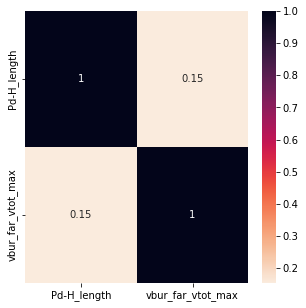

In [5]:
# Let's do an absolute heatmap (and set the color axis so that 0 is light, 1 is dark):
plt.figure(figsize= (5, 5))
cmap = sns.cm.rocket_r
abs_corr_heatmap = sns.heatmap(abs(features.corr()), annot=True, cmap=cmap)

In [6]:
# Set the feature and target values:
X = features.values
target = merged_df.columns[1]
y = merged_df[target].values

In [7]:
# Leave-one-out CV
from sklearn.model_selection import LeaveOneOut
def loocv(X, y, model, verbose=False):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    y_preds = []
    for i, (train_indices, test_index) in enumerate(loo.split(X)):
        print(f"Fold {i}: ", end="")
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds.append(y_pred[0])
        print("complete.  ", end="")
        
        if verbose:
            print()
            print(model.coef_)
            print(model.intercept_)
    
    print()
    return y_preds

In [8]:
y_preds = loocv(X, y, LinearRegression(), verbose=True)
# print(y_preds)

Fold 0: complete.  
[72.9604124  0.3545839]
225.61577514408944
Fold 1: complete.  
[71.86989467  0.36294495]
227.8410898424448
Fold 2: complete.  
[74.66610167  0.3606488 ]
221.48903968037084
Fold 3: complete.  
[72.47349136  0.35328745]
226.28308310730205
Fold 4: complete.  
[70.4931434   0.32507753]
231.92656239254953
Fold 5: complete.  
[73.31844031  0.36300748]
224.59557522057708
Fold 6: complete.  
[74.0006654   0.36395011]
222.90574919458393
Fold 7: complete.  
[73.78986135  0.39685932]
223.38735891500275
Fold 8: complete.  
[72.64842336  0.35419541]
226.26345385818558
Fold 9: complete.  
[72.62208543  0.39079767]
225.57555449319779
Fold 10: complete.  
[73.22925897  0.35415988]
225.05714568461664
Fold 11: complete.  
[68.00469952  0.25735974]
238.8978238966675
Fold 12: complete.  
[72.5630229  0.3662336]
226.2108172117885
Fold 13: complete.  
[72.95172249  0.37103143]
225.41441492477466
Fold 14: complete.  
[73.17010984  0.36325018]
225.0143425254283
Fold 15: complete.  
[72.462

In [9]:
# As one might expect with a relatively simple model, the coefficients appear to be pretty stable.

In [10]:
# Compute MSE:
# keep this as is in order to print the SE along with each molecule_id
squared_errors = []
for i in range(len(y_preds)):
    squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
print(f"LOOCV MSE: {round((sum(squared_errors) / len(squared_errors)), 1)}")

LOOCV MSE: 63.8


In [11]:
linear_2feature = LinearRegression()
linear_2feature.fit(X, y)
print(f"Linear, 2-feature coefficients: {linear_2feature.coef_}")
print(f"Linear, 2-feature R2: {linear_2feature.score(X, y)}")

Linear, 2-feature coefficients: [72.95078108  0.35763575]
Linear, 2-feature R2: 0.7154186103186679


In [12]:
# So our R2 is greater than 0.7 and we are predciting lambda max with an average error of around 8 nm, not bad!
# The two feature model is working pretty well then.

<Axes: xlabel='molecule_id', ylabel='squared error'>

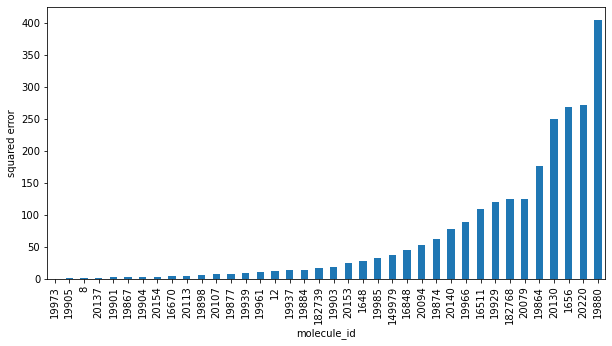

In [13]:
pd.Series(squared_errors, merged_df["molecule_id"]).sort_values(ascending = True).plot(kind = "bar", figsize=(10,5), ylabel="squared error")
# TODO: double check that the labels and the names are correctly corresponding
# same with the other such plots too

<Figure size 432x288 with 0 Axes>

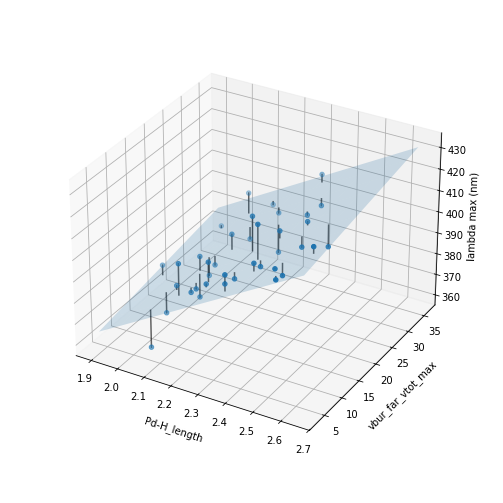

In [14]:
# Plot the plane in 3D:
from mpl_toolkits import mplot3d

fig = plt.figure()
plt.figure(figsize= (9, 9))

ax = plt.axes(projection='3d')

x1_data, x2_data = X.T[0], X.T[1]
ax.scatter3D(x1_data, x2_data, y)

x1_coef, x2_coef, intercept = linear_2feature.coef_[0], linear_2feature.coef_[1], linear_2feature.intercept_
x1lim, x2lim = ax.get_xlim(), ax.get_ylim()
x1, x2 = np.meshgrid(
    np.linspace(x1lim[0], x1lim[1], 10),
    np.linspace(x2lim[0], x2lim[1], 10)
)
y_plane = x1_coef*x1 + x2_coef*x2 + intercept
surf = ax.plot_surface(x1, x2, y_plane, alpha=0.2)

# Plot lines between the data points and the surface:
# Find the z-coordinate of the surface at the data point's x, y coordinates
surface_points_of_data = x1_coef*x1_data + x2_coef*x2_data + intercept
for i in range(len(x1_data)):
    ax.plot3D([x1_data[i], x1_data[i]], [x2_data[i], x2_data[i]], [y[i], surface_points_of_data[i]], c='black', alpha=0.6)

ax.set_xlabel("Pd-H_length", labelpad=10)
ax.set_ylabel("vbur_far_vtot_max", labelpad=10)
ax.set_zlabel("lambda max (nm)")
ax.set_box_aspect(None, zoom=0.85)  # this is needed to prevent the z axis label from getting cut off...

In [15]:
# Also, how much better is out model than a 1-parameter regression with Pd-H length?
# for what that model would lack in flexibility it may just fare well due to not overfitting...
# basically, does the Kraken ML data really add anything or not, is it actually learning from that stuff
from sklearn.linear_model import LinearRegression
import numpy as np

linear_agostic = LinearRegression()
X_PdH = merged_df.loc[:, ["Pd-H_length"]].to_numpy()
linear_agostic.fit(X_PdH, y)

print(f"Linear, agostic R2: {linear_agostic.score(X_PdH, y)}")

Linear, agostic R2: 0.6737617465939237


In [16]:
y_preds = loocv(X_PdH, y, linear_agostic)
# print(y_preds)

Fold 0: complete.  Fold 1: complete.  Fold 2: complete.  Fold 3: complete.  Fold 4: complete.  Fold 5: complete.  Fold 6: complete.  Fold 7: complete.  Fold 8: complete.  Fold 9: complete.  Fold 10: complete.  Fold 11: complete.  Fold 12: complete.  Fold 13: complete.  Fold 14: complete.  Fold 15: complete.  Fold 16: complete.  Fold 17: complete.  Fold 18: complete.  Fold 19: complete.  Fold 20: complete.  Fold 21: complete.  Fold 22: complete.  Fold 23: complete.  Fold 24: complete.  Fold 25: complete.  Fold 26: complete.  Fold 27: complete.  Fold 28: complete.  Fold 29: complete.  Fold 30: complete.  Fold 31: complete.  Fold 32: complete.  Fold 33: complete.  Fold 34: complete.  Fold 35: complete.  Fold 36: complete.  Fold 37: complete.  


In [17]:
def calc_squared_errors(y_preds, y):
    squared_errors = []
    for i in range(len(y_preds)):
        squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
    return squared_errors

def calc_mse(y_preds, y):
    squared_errors = calc_squared_errors(y_preds, y)
    return round((sum(squared_errors) / len(squared_errors)), 1)


print(f"LOOCV MSE: {calc_mse(y_preds, y)}")

LOOCV MSE: 69.7


In [18]:
# Bootstrap CV: 2-feature linear model
from sklearn.utils import resample


def two_feature_bootstrap(bootstrap_data, model, verbose=False):  # yeah I know, not the most efficient abstraction...
    boot_training = resample(bootstrap_data, replace=True, n_samples=len(bootstrap_data))
    test = np.array([x for x in bootstrap_data if x.tolist() not in boot_training.tolist()])
    
    train_X = np.c_[boot_training.T[0], boot_training.T[1]]
    train_y = boot_training.T[2]
    test_X = np.c_[test.T[0], test.T[1]]
    test_y = test.T[2]
    
    if verbose:
        print(f"train_X:\n{train_X}")
        print(f"train_y:\n{train_y}")
        print(f"test_X:\n{test_X}")
        print(f"test_y:\n{test_y}")
    
    model.fit(train_X, train_y)
    y_preds = model.predict(test_X)
    return calc_mse(y_preds, test_y)


bootstrap_data = np.c_[X, y]
model = LinearRegression()

bootstrap_mses = []
for i in range(5000):
    bootstrap_mses.append(two_feature_bootstrap(bootstrap_data, model))
    
print(f"5000-iteration average bootstrap MSE, 2-feature model: {round((sum(bootstrap_mses) / len(bootstrap_mses)), 1)}")

5000-iteration average bootstrap MSE, 2-feature model: 68.2


In [19]:
# Bootstrap CV: 1-feature linear model

def one_feature_bootstrap(bootstrap_data, model, verbose=False):  # again, not the most efficient abstraction...
    boot_training = resample(bootstrap_data, replace=True, n_samples=len(bootstrap_data))
    test = np.array([x for x in bootstrap_data if x.tolist() not in boot_training.tolist()])
    
    train_X = boot_training.T[0].reshape(-1, 1)
    train_y = boot_training.T[2]
    test_X = test.T[0].reshape(-1, 1)
    test_y = test.T[2]

    if verbose:
        print(f"train_X:\n{train_X}")
        print(f"train_y:\n{train_y}")
        print(f"test_X:\n{test_X}")
        print(f"test_y:\n{test_y}")
    
    model.fit(train_X, train_y)
    model.fit(train_X, train_y)
    y_preds = model.predict(test_X)
    return calc_mse(y_preds, test_y)


bootstrap_data = np.c_[X, y]
model = LinearRegression()

bootstrap_mses = []
for i in range(5000):
    bootstrap_mses.append(one_feature_bootstrap(bootstrap_data, model))

print(f"5000-iteration average bootstrap MSE, 1-feature model: {round((sum(bootstrap_mses) / len(bootstrap_mses)), 1)}")

5000-iteration average bootstrap MSE, 1-feature model: 73.7
